In [1]:
""" Auto Encoder Example.
Using an auto encoder on MNIST handwritten digits.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""

' Auto Encoder Example.\nUsing an auto encoder on MNIST handwritten digits.\nReferences:\n    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based\n    learning applied to document recognition." Proceedings of the IEEE,\n    86(11):2278-2324, November 1998.\nLinks:\n    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/\n'

In [2]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("~/data/", one_hot=True)

Extracting ~/data/train-images-idx3-ubyte.gz
Extracting ~/data/train-labels-idx1-ubyte.gz
Extracting ~/data/t10k-images-idx3-ubyte.gz
Extracting ~/data/t10k-labels-idx1-ubyte.gz


In [3]:
def deconv2d(x, W, stride):
    strides=[1, stride, stride, 1];
    inshape = x.get_shape().as_list();
    kernel_shape = W.get_shape().as_list(); 
    output_shape = tf.pack([tf.shape(x)[0], tf.shape(x)[1]*strides[1], tf.shape(x)[2]*strides[2], kernel_shape[2]]);
    #print(output_shape);
    return tf.nn.conv2d_transpose(x, W, output_shape=output_shape, strides=strides, padding='SAME')

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [4]:
# Parameters
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# Network Parameters
#n_hidden_1 = 256 # 1st layer num features
#n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder(tf.float32, shape=[None, n_input])

weights = {
    'encoder_W_conv1': weight_variable([5, 5, 1, 32]),
    'encoder_W_conv2': weight_variable([5, 5, 32, 64]),
    'encoder_W_fc1': weight_variable([7 * 7 * 64, 1024]),
    'encoder_W_fc2': weight_variable([1024, 256]),
    'decoder_W_fc3': weight_variable([256, 1024]),
    'decoder_W_fc4': weight_variable([1024, 7 * 7 * 64]),
    'decoder_W_deconv1': weight_variable([5, 5, 32, 64]),
    'decoder_W_deconv2': weight_variable([5, 5, 1, 32]),
}
biases = {
    'encoder_b_conv1': bias_variable([32]),
    'encoder_b_conv2': bias_variable([64]),
    'encoder_b_fc1': bias_variable([1024]),
    'encoder_b_fc2': bias_variable([256]),
    'decoder_b_fc3': bias_variable([1024]),
    'decoder_b_fc4': bias_variable([7 * 7 * 64]),
    'decoder_b_deconv1': bias_variable([32]),
    'decoder_b_deconv2': bias_variable([1]),
}


In [5]:

# Building the encoder
def encoder(x):
    x_image = tf.reshape(x, [-1,28,28,1])
    h_conv1 = tf.nn.relu(conv2d(x_image, weights['encoder_W_conv1']) + biases['encoder_b_conv1'])
    #print(sess.run(tf.pack(h_conv1.get_shape().as_list()[1:])));
    h_pool1 = max_pool_2x2(h_conv1)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, weights['encoder_W_conv2']) + biases['encoder_b_conv2'])
    h_pool2 = max_pool_2x2(h_conv2)
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, weights['encoder_W_fc1']) + biases['encoder_b_fc1'])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, weights['encoder_W_fc2']) + biases['encoder_b_fc2'])
    # Encoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
    #                               biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
    #                               biases['encoder_b2']))
    return h_fc2


# Building the decoder
def decoder(x):
    h_fc3 = tf.nn.relu(tf.matmul(x, weights['decoder_W_fc3']) + biases['decoder_b_fc3'])
    h_fc4 = tf.nn.relu(tf.matmul(h_fc3, weights['decoder_W_fc4']) + biases['decoder_b_fc4'])
    h_fc4_square = tf.reshape(h_fc4, [-1, 7, 7, 64])
    #print(sess.run(tf.pack(h_fc4_square.get_shape().as_list()[1:])));
    h_deconv1 = tf.nn.relu(deconv2d(h_fc4_square, weights['decoder_W_deconv1'], 2) + biases['decoder_b_deconv1'])
    #print(sess.run(tf.pack(h_deconv1.get_shape().as_list()[3:])));
    h_deconv2 = tf.nn.sigmoid(deconv2d(h_deconv1, weights['decoder_W_deconv2'], 2) + biases['decoder_b_deconv2'])
    # Encoder Hidden layer with sigmoid activation #1
    #layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
    #                               biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
    #                               biases['decoder_b2']))
    return tf.reshape(h_deconv2, [-1, 784])

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

Epoch: 0001 cost= 0.061858904
Epoch: 0002 cost= 0.024184363
Epoch: 0003 cost= 0.017681569
Epoch: 0004 cost= 0.015565721
Epoch: 0005 cost= 0.013441658
Epoch: 0006 cost= 0.011664211
Epoch: 0007 cost= 0.011975487
Epoch: 0008 cost= 0.010883696
Epoch: 0009 cost= 0.009465900
Epoch: 0010 cost= 0.009675261
Epoch: 0011 cost= 0.012413001
Epoch: 0012 cost= 0.010786624
Epoch: 0013 cost= 0.008704969
Epoch: 0014 cost= 0.010415017
Epoch: 0015 cost= 0.009385062
Epoch: 0016 cost= 0.007615013
Epoch: 0017 cost= 0.008445629
Epoch: 0018 cost= 0.008830262
Epoch: 0019 cost= 0.007214088
Epoch: 0020 cost= 0.006849539
Optimization Finished!


/Users/nalwaya/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


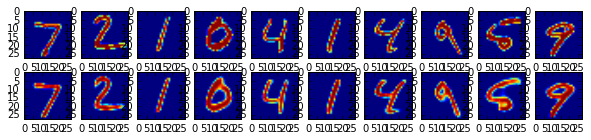

In [6]:
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)

total_batch = int(mnist.train.num_examples/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(c))

print("Optimization Finished!")

# Applying encode and decode over test set
encode_decode = sess.run(
    y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
f.show()
plt.draw()
#plt.waitforbuttonpress()

In [7]:
# Result

****Looking at some TRAINING samples as well : useful to check overfitting


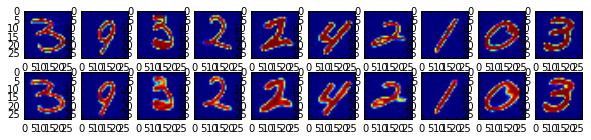

In [8]:
# display plots in this notebook
# Applying encode and decode over test set
print('****Looking at some TRAINING samples as well : useful to check overfitting')
encode_decode = sess.run(
    y_pred, feed_dict={X: mnist.train.images[:examples_to_show]})
#print(sess.run(cost, feed_dict={X: mnist.train.images[:examples_to_show]}))
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.train.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
f.show()
plt.draw()
#plt.waitforbuttonpress()